## and incorrect ones too!

In [67]:
from acfunctions import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import astropy.stats as astat
from solartwins import *
import pickle
from IPython.display import Image, display, HTML
import starspot as ss
import starspot.rotation_tools as rt
from starspot import sigma_clipping
import lightkurve as lk
from lightkurve import search_targetpixelfile, search_lightcurvefile
import math
import exoplanet
import eleanor
from astropy.coordinates import SkyCoord
from scipy import interpolate
from tess_kep_funct import *
from tqdm import tqdm
from scipy import misc
from bokeh.models import ColumnDataSource, LabelSet, Whisker
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
from bokeh.sampledata.autompg import autompg as df

import warnings
warnings.filterwarnings("ignore")

In [68]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=False)

In [69]:
output_notebook()

Loading BokehJS ...

In [70]:
#dataset with tess vs kepler IDs
tess_kep = pd.read_csv('data_summary.csv')
tess_short = tess_kep[tess_kep.tess_ffi == True]
cat = pd.read_csv('tics_kics_mcq_rot.txt', names=['tic_id', 'kic_id', 'prot'], delim_whitespace=True)

In [71]:
#importing McQ periods
headers = 'TIC ID', 'KIC ID', 'McQ Periods';  

with open("tics_kics_mcq_rot.txt") as file:
    rot_table = [line.split() for line in file.read().splitlines()]

widths = [max(len(value) for value in col)
for col in zip(*(rot_table + [headers]))]

formatting = '{:{widths[0]}}  {:{widths[1]}}  {:{widths[2]}}'
formatting.format(*headers, widths=widths)
for tics_kics_mcq in rot_table:
    formatting.format(*tics_kics_mcq, widths=widths)

In [72]:
# converting txt file data to arrays
tic_ids = []
mcq_periods = []

for index, row in enumerate(rot_table):
    tic_ids.append(int(rot_table[index][0]))
    mcq_periods.append(float(rot_table[index][2]))

In [73]:
# selecting shortest periods only (<13 days, half a tess cycle)
short_periods = []
tics_short_periods = []

for index, period in enumerate(mcq_periods):
    if period < 13: 
        short_periods.append(period)
        tics_short_periods.append(tic_ids[index])
        
#limiting to the first 60
#short_periods = short_periods[0:61]
#tics_short_periods = tics_short_periods[0:61]

In [74]:
with open('pdm_periods_resid.data', 'rb') as filehandle:
    pdm_periods_resid = pickle.load(filehandle) 

In [75]:
with open('ls_periods_resid.data', 'rb') as filehandle:
    ls_periods_resid = pickle.load(filehandle) 

In [76]:
with open('exo_periods_resid.data', 'rb') as filehandle:
    exo_periods_resid = pickle.load(filehandle) 

In [77]:
with open('pdm_error.data', 'rb') as filehandle:
    pdm_error = pickle.load(filehandle) 

In [78]:
with open('mcq_exo_difference.data', 'rb') as filehandle:
    mcq_exo_difference = pickle.load(filehandle) 

In [79]:
pdm_resid_periods = []
for each, value in enumerate(pdm_periods_resid): 
    if value == 'NaN':
        pdm_resid_periods.append(0)
    else: 
        pdm_resid_periods.append(value)

In [80]:
ls_resid_periods = []
for each, value in enumerate(ls_periods_resid): 
    if value == 'NaN':
        ls_resid_periods.append(0)
    else: 
        ls_resid_periods.append(value)

In [81]:
exo_resid_periods = []
for each, value in enumerate(exo_periods_resid): 
    if value == 'NaN':
        exo_resid_periods.append(0)
    else: 
        exo_resid_periods.append(value)

In [102]:
pdm_correct = [] #indexes of stars with calculated periods within 0.25 of the McQuillan period
pdm_incorrect = []
pdm_2x = []
pdm_half_x = []
pdm_diff = []

for indx, per in enumerate(short_periods[0:61]):
    diff = np.abs(per - (pdm_resid_periods[indx]))
    pdm_diff.append(diff)
    if diff <= 0.25:
        pdm_correct.append(indx)
        
    else: 
        two_x_diff = np.abs((2*per) - (pdm_resid_periods[indx]))
        if two_x_diff <= 0.25:
            pdm_2x.append(indx)
        
        half_diff = np.abs((per/2) - (pdm_resid_periods[indx]))
        if half_diff <= 0.25:
            pdm_half_x.append(indx)
        
        else:
            pdm_incorrect.append(indx)

In [83]:
print(pdm_correct)

[13, 16, 19, 22, 27, 34, 40, 45, 47, 60]


In [104]:
ls_correct = [] #indexes of stars with calculated periods within 0.25 of the McQuillan period
ls_incorrect = []
ls_2x = []
ls_half_x = []
ls_diff = []

for indx, per in enumerate(short_periods[0:61]):
    diff = np.abs(per - (ls_resid_periods[indx]))
    ls_diff.append(diff)
    if diff <= 0.25:
        ls_correct.append(indx)
        
    else: 
        two_x_diff = np.abs((2*per) - (ls_resid_periods[indx]))
        if two_x_diff <= 0.25:
            ls_2x.append(indx)
        
        half_diff = np.abs((per/2) - (ls_resid_periods[indx]))
        if half_diff <= 0.25:
            ls_half_x.append(indx)
        
        else:
            ls_incorrect.append(indx)

In [85]:
ls_half_x

[16, 42, 45]

In [99]:
exo_correct = [] #indexes of stars with calculated periods within 0.25 of the McQuillan period
exo_incorrect = []
exo_2x = []
exo_half_x = []
exo_diff = []


for indx, per in enumerate(short_periods[0:61]):
    diff = np.abs(per - (exo_resid_periods[indx]))
    exo_diff.append(diff)
    if diff <= 0.25:
        exo_correct.append(indx)
        
    else: 
        two_x_diff = np.abs((2*per) - (exo_resid_periods[indx]))
        if two_x_diff <= 0.25:
            exo_2x.append(indx)
        
        half_diff = np.abs((per/2) - (exo_resid_periods[indx]))
        if half_diff <= 0.25:
            exo_half_x.append(indx)
        
        else:
            exo_incorrect.append(indx)

In [87]:
exo_correct

[16, 19, 21, 22, 27, 29, 30, 31, 37, 40, 45, 47, 55, 60]

(array([17.,  8.,  5.,  5.,  6.,  3.,  4.,  5.,  5.,  3.]),
 array([1.31872291e-12, 1.04500000e+00, 2.09000000e+00, 3.13500000e+00,
        4.18000000e+00, 5.22500000e+00, 6.27000000e+00, 7.31500000e+00,
        8.36000000e+00, 9.40500000e+00, 1.04500000e+01]),
 <a list of 10 Patch objects>)

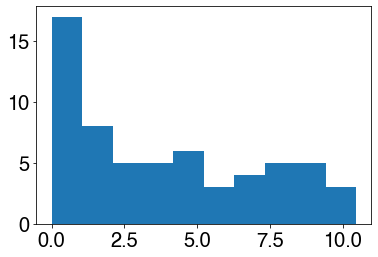

In [101]:
plt.hist(exo_diff)

(array([14.,  8.,  7., 14.,  8.,  2.,  3.,  2.,  2.,  1.]),
 array([4.23423423e-03, 1.15512613e+00, 2.30601802e+00, 3.45690991e+00,
        4.60780180e+00, 5.75869369e+00, 6.90958559e+00, 8.06047748e+00,
        9.21136937e+00, 1.03622613e+01, 1.15131532e+01]),
 <a list of 10 Patch objects>)

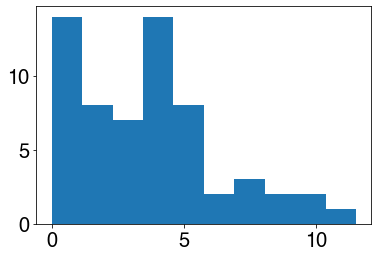

In [103]:
plt.hist(pdm_diff)

(array([14.,  7.,  4.,  6.,  5., 12.,  3.,  4.,  3.,  3.]),
 array([2.24316552e-03, 8.62018849e-01, 1.72179453e+00, 2.58157022e+00,
        3.44134590e+00, 4.30112158e+00, 5.16089727e+00, 6.02067295e+00,
        6.88044863e+00, 7.74022432e+00, 8.60000000e+00]),
 <a list of 10 Patch objects>)

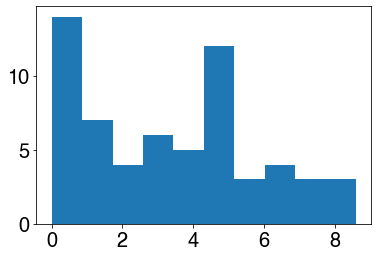

In [106]:
plt.hist(ls_diff)

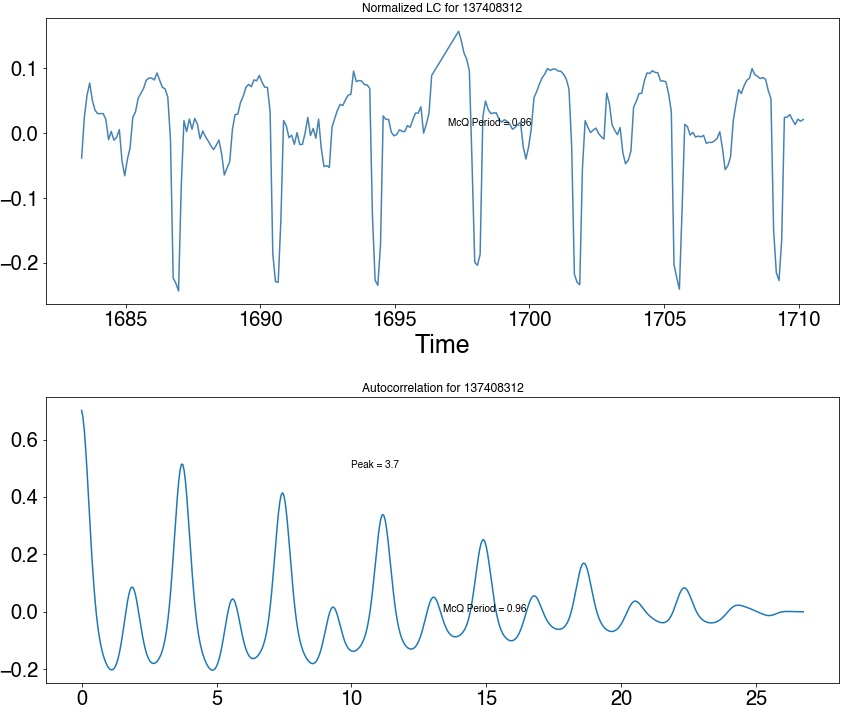

In [88]:
Image(filename='tess_16_flux_ac.jpg') 

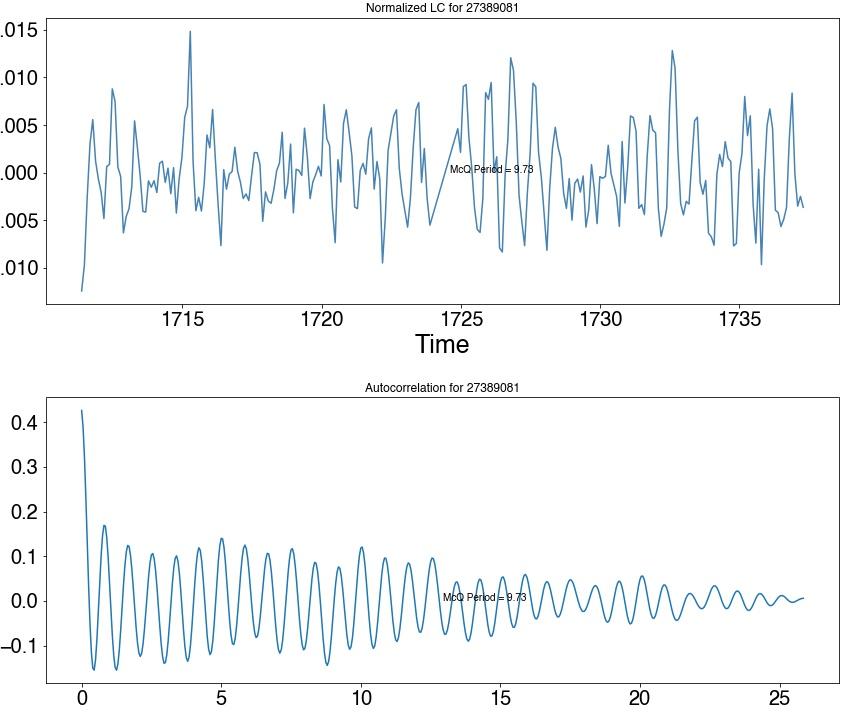

In [89]:
Image(filename='tess_19_flux_ac.jpg') 

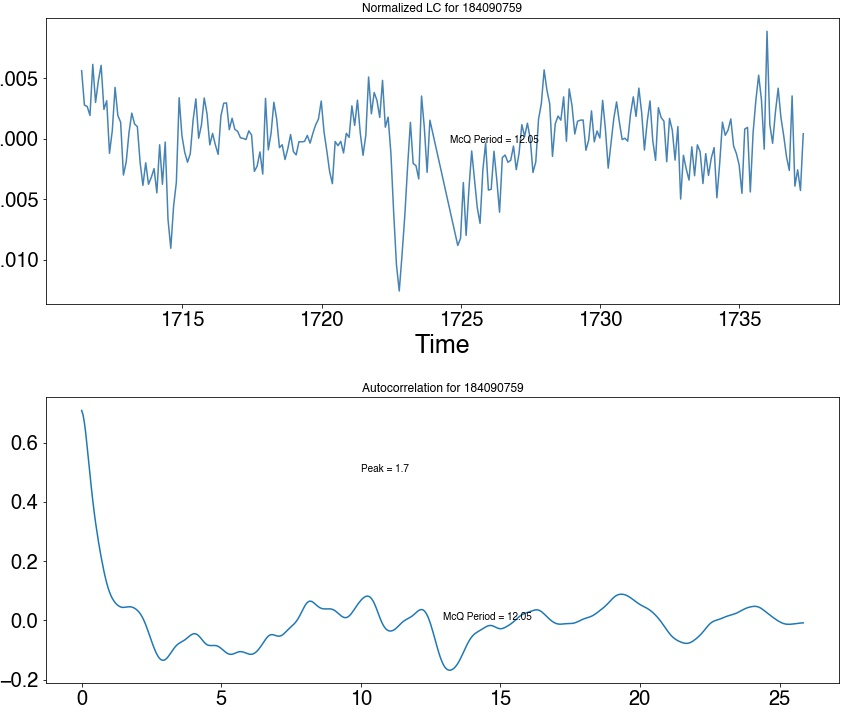

In [90]:
Image(filename='tess_21_flux_ac.jpg') 

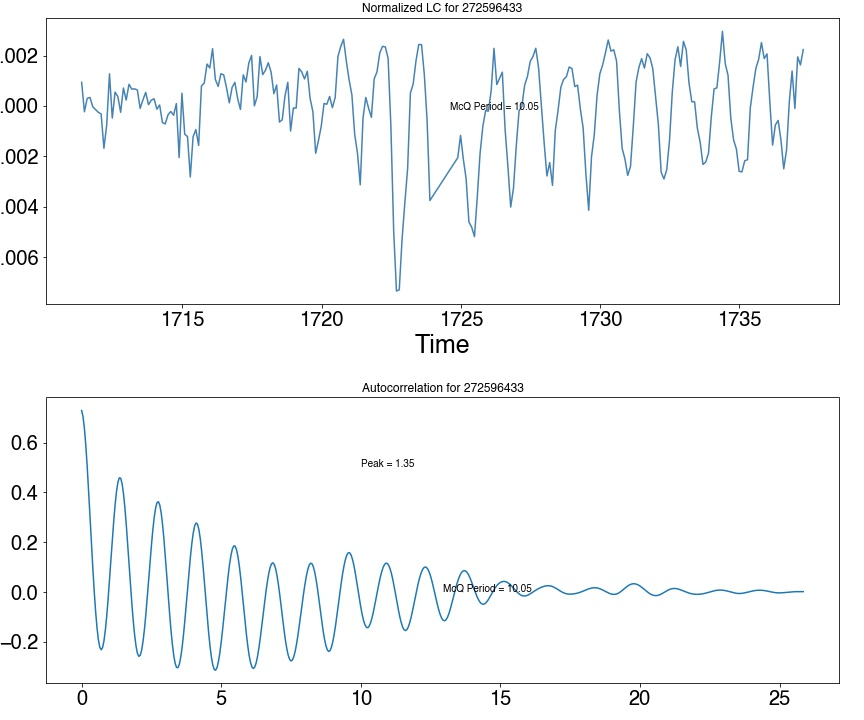

In [91]:
Image(filename='tess_22_flux_ac.jpg') 

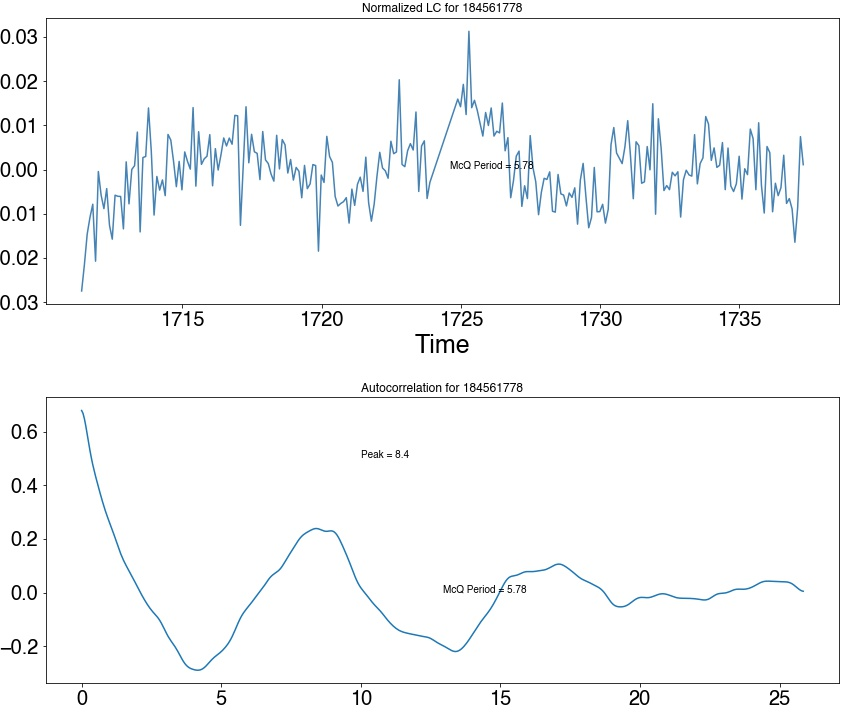

In [92]:
Image(filename='tess_60_flux_ac.jpg') 

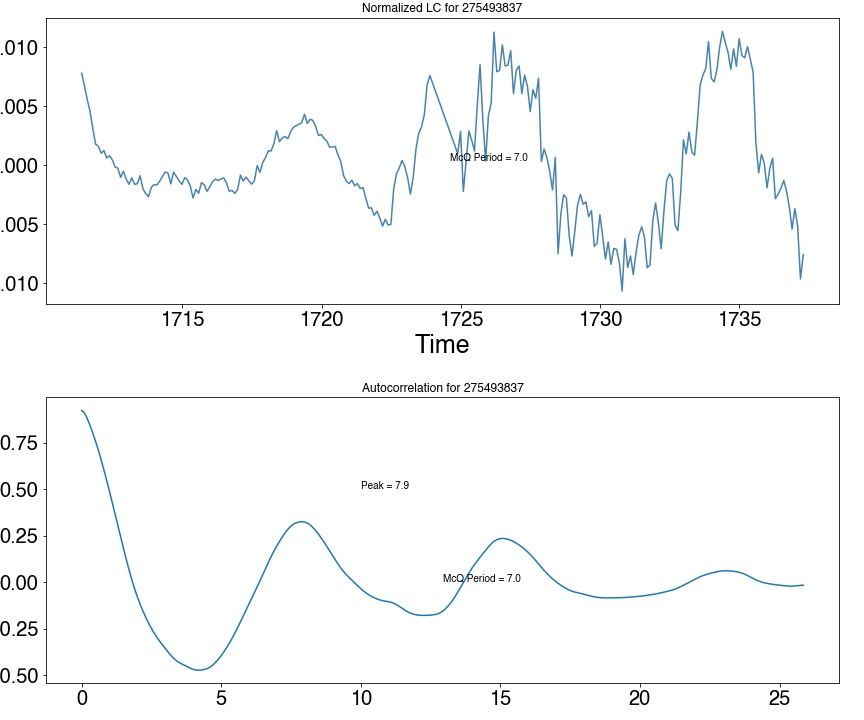

In [93]:
num = exo_incorrect[0]
Image(filename='tess_{0}_flux_ac.jpg'.format(num)) 

In [94]:
exo_incorrect[1]

2

In [95]:
mcq_per_incorrect = []
for each, per in enumerate(exo_incorrect):
    mcq_per_incorrect.append(short_periods[per])
    
mcq_per_correct = []
for each, per in enumerate(exo_correct):
    mcq_per_correct.append(short_periods[per])

(array([4., 9., 3., 1., 4., 5., 4., 3., 6., 6.]),
 array([ 0.96 ,  2.147,  3.334,  4.521,  5.708,  6.895,  8.082,  9.269,
        10.456, 11.643, 12.83 ]),
 <a list of 10 Patch objects>)

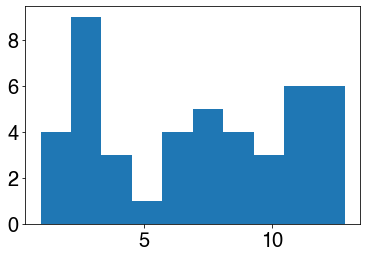

In [96]:
plt.hist(mcq_per_incorrect)

(array([3., 5., 1., 1., 1., 0., 0., 2., 0., 1.]),
 array([0.57 , 1.367, 2.164, 2.961, 3.758, 4.555, 5.352, 6.149, 6.946,
        7.743, 8.54 ]),
 <a list of 10 Patch objects>)

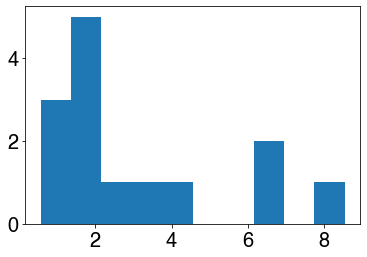

In [97]:
plt.hist(mcq_per_correct)

(array([11.,  9.,  8.,  0.,  6.,  4.,  8.,  3.,  6.,  6.]),
 array([ 0.57 ,  1.796,  3.022,  4.248,  5.474,  6.7  ,  7.926,  9.152,
        10.378, 11.604, 12.83 ]),
 <a list of 10 Patch objects>)

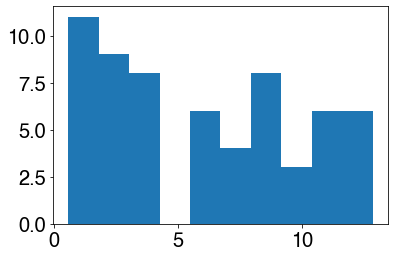

In [98]:
plt.hist(short_periods[0:61])